In [1]:
import numpy as np
import matplotlib.pyplot as plt



In [2]:
class GridWorld:
    def __init__(self):
        self.rows = 6
        self.cols = 6
        self.start_state = (5, 0)
        self.terminal_states = [(0, 5), (5, 5)]
        self.red_states = [(2, i) for i in range(1, 5)]
        self.action_space = ['U', 'D', 'L', 'R']
        self.state = self.start_state

    def reset(self):
        self.state = self.start_state
        return self.state

    def step(self, action):
        row, col = self.state
        if action == 'U':
            next_state = (row - 1, col)
        elif action == 'D':
            next_state = (row + 1, col)
        elif action == 'L':
            next_state = (row, col - 1)
        elif action == 'R':
            next_state = (row, col + 1)
        else:
            next_state = (row, col)

        # Check if out of bounds
        if not (0 <= next_state[0] < self.rows and 0 <= next_state[1] < self.cols):
            reward = -1
            next_state = self.state
            done = False
        elif next_state in self.terminal_states:
            reward = -1
            done = True
        elif next_state in self.red_states:
            reward = -20
            next_state = self.start_state
            done = False
        else:
            reward = -1
            done = False

        self.state = next_state
        return next_state, reward, done



In [3]:
env = GridWorld()
print("Start state:", env.start_state)
print("Terminal states:", env.terminal_states)
print("Red wall states:", env.red_states)
print("Sample reset state:", env.reset())

s, r, d = env.step('R')
print("Step right: state =", s, "reward =", r, "done =", d)



Start state: (5, 0)
Terminal states: [(0, 5), (5, 5)]
Red wall states: [(2, 1), (2, 2), (2, 3), (2, 4)]
Sample reset state: (5, 0)
Step right: state = (5, 1) reward = -1 done = False


In [4]:
Q = {}
for i in range(6):
    for j in range(6):
        for a in env.action_space:
            Q[((i, j), a)] = 0

print("Example Q value for (5,0),'R':", Q[((5,0),'R')])



Example Q value for (5,0),'R': 0


In [5]:
def epsilon_greedy(Q, state, epsilon=0.1):
    if np.random.rand() < epsilon:
        return np.random.choice(env.action_space)
    else:
        vals = [Q[(state, a)] for a in env.action_space]
        maxs = np.where(vals == np.max(vals))[0]
        idx = np.random.choice(maxs)
        return env.action_space[idx]



In [6]:
test_state = (5, 0)
print("Test epsilon-greedy:", epsilon_greedy(Q, test_state, epsilon=0.2))



Test epsilon-greedy: U


In [7]:
def run_sarsa(env, episodes=300, alpha=0.1, gamma=0.95, epsilon=0.1):
    Q = {}
    for i in range(6):
        for j in range(6):
            for a in env.action_space:
                Q[((i, j), a)] = 0
    rewards = []
    for ep in range(episodes):
        s = env.reset()
        a = epsilon_greedy(Q, s, epsilon)
        total_r = 0
        steps = 0
        while True:
            s_, r, done = env.step(a)
            a_ = epsilon_greedy(Q, s_, epsilon)
            Q[(s, a)] += alpha * (r + gamma * Q[(s_, a_)] - Q[(s, a)])
            s, a = s_, a_
            total_r += r
            steps += 1
            if done or steps > 100:
                break
        rewards.append(total_r)
        if ep % 50 == 0:
            print(f"Episode {ep}, total reward: {total_r}")
    return Q, rewards



In [8]:
sarsa_Q, sarsa_rewards = run_sarsa(env, episodes=300, alpha=0.1, gamma=0.99, epsilon=0.1)
print("Final SARSA Q value (5,0,'R'):", sarsa_Q[((5,0),'R')])



Episode 0, total reward: -177
Episode 50, total reward: -42
Episode 100, total reward: -31
Episode 150, total reward: -5
Episode 200, total reward: -6
Episode 250, total reward: -5
Final SARSA Q value (5,0,'R'): -5.089335807068602


In [9]:
def run_qlearning(env, episodes=300, alpha=0.1, gamma=0.95, epsilon=0.1):
    Q = {}
    for i in range(6):
        for j in range(6):
            for a in env.action_space:
                Q[((i, j), a)] = 0
    rewards = []
    for ep in range(episodes):
        s = env.reset()
        total_r = 0
        steps = 0
        while True:
            a = epsilon_greedy(Q, s, epsilon)
            s_, r, done = env.step(a)
            max_q = max([Q[(s_, b)] for b in env.action_space])
            Q[(s, a)] += alpha * (r + gamma * max_q - Q[(s, a)])
            s = s_
            total_r += r
            steps += 1
            if done or steps > 100:
                break
        rewards.append(total_r)
        if ep % 50 == 0:
            print(f"Q-learning episode {ep}, reward: {total_r}")
    return Q, rewards



In [10]:
qlearn_Q, qlearn_rewards = run_qlearning(env, episodes=300, alpha=0.1, gamma=0.99, epsilon=0.1)
print("Final Q-learning Q value (5,0,'R'):", qlearn_Q[((5,0),'R')])



Q-learning episode 0, reward: -177
Q-learning episode 50, reward: -30
Q-learning episode 100, reward: -10
Q-learning episode 150, reward: -5
Q-learning episode 200, reward: -5
Q-learning episode 250, reward: -5
Final Q-learning Q value (5,0,'R'): -4.900994423575847


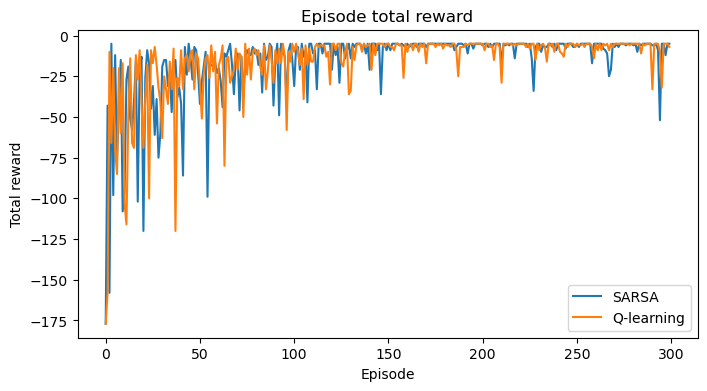

In [11]:
plt.figure(figsize=(8,4))
plt.plot(sarsa_rewards, label='SARSA')
plt.plot(qlearn_rewards, label='Q-learning')
plt.xlabel('Episode')
plt.ylabel('Total reward')
plt.legend()
plt.title("Episode total reward")
plt.show()



In [12]:
def get_greedy_policy(Q):
    policy = {}
    for i in range(6):
        for j in range(6):
            state = (i,j)
            vals = [Q[(state,a)] for a in env.action_space]
            idx = np.argmax(vals)
            policy[state] = env.action_space[idx]
    return policy

def test_policy_trajectory(env, policy):
    traj = [env.start_state]
    s = env.reset()
    for _ in range(20):
        a = policy[s]
        s_, r, done = env.step(a)
        traj.append(s_)
        s = s_
        if done:
            break
    print("Trajectory:", traj)
    return traj

sarsa_policy = get_greedy_policy(sarsa_Q)
sarsa_traj = test_policy_trajectory(env, sarsa_policy)

qlearn_policy = get_greedy_policy(qlearn_Q)
qlearn_traj = test_policy_trajectory(env, qlearn_policy)



Trajectory: [(5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]
Trajectory: [(5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5)]


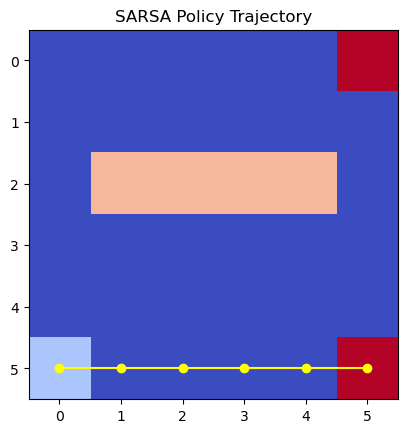

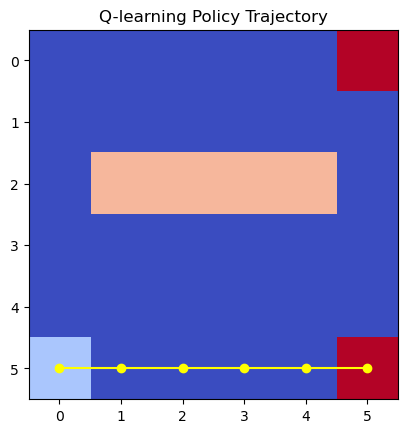

In [13]:
def plot_trajectory(traj, env, title='Policy Trajectory'):
    grid = np.zeros((env.rows, env.cols))
    for s in env.red_states:
        grid[s] = 2
    for s in env.terminal_states:
        grid[s] = 3
    grid[env.start_state] = 1
    plt.imshow(grid, cmap='coolwarm', origin='upper')
    traj = np.array(traj)
    plt.plot(traj[:,1], traj[:,0], marker='o', color='yellow')
    plt.title(title)
    plt.show()

plot_trajectory(sarsa_traj, env, title='SARSA Policy Trajectory')
plot_trajectory(qlearn_traj, env, title='Q-learning Policy Trajectory')

